# The DFT: Numerical Aspects

In this notebook we will look at some numerical issues associated to the DFT; in particular we we will look at the differences in precision between the "naive" way of computing the DFT and the FFT algorithm.
 
As a quick reminder, the definitions of the direct and inverse DFT for a length-$N$ signal are:

\begin{align*}
    X[k] &= \sum_{n=0}^{N-1} x[n]\, e^{-j\frac{2\pi}{N}nk}, \quad k=0, \ldots, N-1 \\
    x[n] &= \frac{1}{N}\sum_{k=0}^{N-1} X[k]\, e^{j\frac{2\pi}{N}nk}, \quad n=0, \ldots, N-1
\end{align*}

The DFT produces a complex-valued vector that we can represent either via its real and imaginary parts or via its magnitude $|X[k]|$ and phase $\angle X[k] = \arctan \frac{\text{Im}\{X[k]\}}{\text{Re}\{X[k]\}}$.

## Direct Implementation

### Numerical errors in real and imaginary parts

The DFT can be easily implemented using the change of basis matrix ${W}_N$. This is an $N\times N$ complex-valued matrix whose elements are 

$$
    {W}_N(n,k)=e^{-j\frac{2\pi}{N}nk}
$$

so that the DFT of a vector $\mathbf{x}$ is simply $\mathbf{X} = W_N\mathbf{x}$. Note that the inverse DFT can be obtained by simply conjugating ${W}_N$ so that $\mathbf{x} = W_N^*\mathbf{X}$.

We can easily generate the matrix ${W}_N$ in Python like so:

In [1]:
# first our usual bookkeeping
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dft_matrix(N):
    # create a 1xN matrix containing indices 0 to N-1
    a = np.expand_dims(np.arange(N), 0)
    
    # take advantage of numpy broadcasting to create the matrix
    W = np.exp(-2j * (np.pi / N) * (a.T * a))
    
    return W

Let's try it out on a short signal and verify the invertibility of the transform

In [3]:
x = np.array([5, 7, 9])

# DFT matrix
N = len(x)
W = dft_matrix(N);

# DFT
X = np.dot(W, x)
# inverse DFT
x_hat = np.dot(W.T.conjugate(), X) / N

print x-x_hat

[ -8.88178420e-16 +3.25665421e-15j   0.00000000e+00 +3.70074342e-17j
   0.00000000e+00 -1.77635684e-15j]


As you can see, the difference between the original vector and the "reconstructed" vector is not exactly zero. This is due to the small numerical errors that accumulate in the $N^2$ multiplications and additions needed by the direct and inverse transforms. 

While minor in this case, this numerical imprecision can be very annoying if we switch to a magnitude/phase representation, as we will see now. 

### Numerical errors in phase

Let's first define a more interesting signal such as a length-128 step signal: 

$$
    x[n] = \begin{cases}
            1 & \mbox{for $0 \leq n < 64$} \\
            0 & \mbox{for $64 \leq n < 128$}
        \end{cases}
$$

Conveniently, we can compute its DFT analytically (it's just a geometric series) and we have 

$$
    X[k] = \begin{cases}
            64 & \mbox{for $k=0$} \\
            0 & \mbox{for $k \neq 0$, $k$ even} \\
            \frac{(-1)^{(k-1)/2}\,e^{-j\pi\frac{63}{128}k}}{\sin(\frac{\pi}{128}k)} & \mbox{for $k$ odd}
        \end{cases}
$$

From this it's easy to compute the phase; we will set its value to zero whenever the magnitude is zero (i.e. for even-indexed values) and we have

$$
    \angle X[k] = \begin{cases}
            0 & \mbox{for $k$ even} \\
            -\pi + \frac{\pi}{128}k & \mbox{for $k$ odd}
        \end{cases}
$$

However, let's see what happens if we compute all of this numerically:

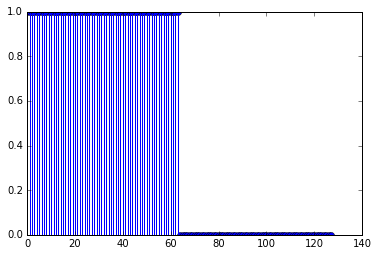

In [4]:
N = 128
x = np.zeros(N)
x[0:64] = 1

plt.stem(x);

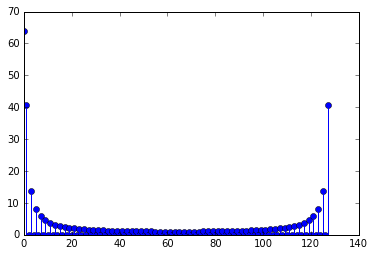

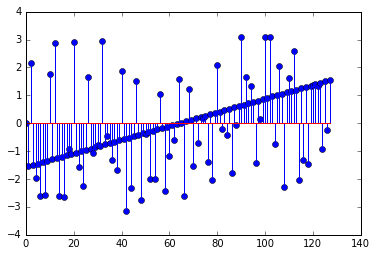

In [5]:
W = dft_matrix(N);

# DFT
X = np.dot(W, x)
plt.stem(abs(X));
show();

plt.stem(np.angle(X));

Clearly we have a problem with the phase, although the magnitude looks nice. This is inherent to the fact that the phase is computed by taking the arctangent of a ratio. When the computed DFT values are close to zero, the denominator of the ratio will be also close to zero and any numerical error in its value will lead to large errors in the phase. As we will see in the next section, this problem can be alleviated by using smarter algorithms than the direct naive method.

Let's still verify the inverse DFT:

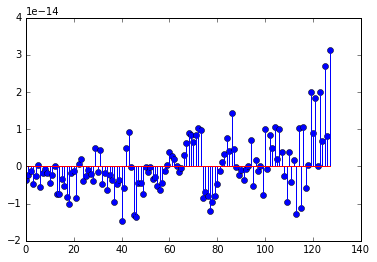

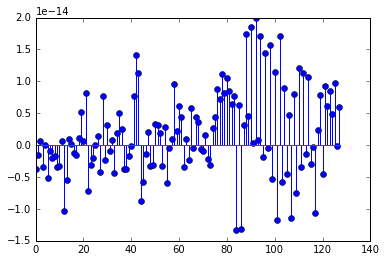

In [6]:
x_hat = np.dot(W.T.conjugate(), X) / N

plt.stem(np.real(x_hat - x));
show();
plt.stem(np.imag(x_hat));

Again, the error is very small but clearly not zero.

## The FFT Algorithm

The FFT algorithm computes the DFT recursively by successively splitting the data vector into smaller pieces and recombining the results. The most well-known version of the FFT operates on data lengths that are a power of two but efficient algorithms exist for all lengths that are factorizable into powers of small primes. 

The FFT algorithm is not only much faster than the direct method but it's also better conditioned numerically. This is because in the FFT implementation great care is applied to minimizing the number of trigonometric factors.

As you can see in the examples below, the phase is now accurate and the reconstruction error is almost two orders of magnitude smaller, basically equal to the numerical precision of floating point variables. 

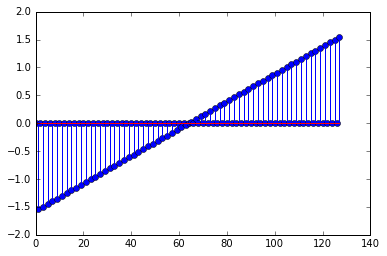

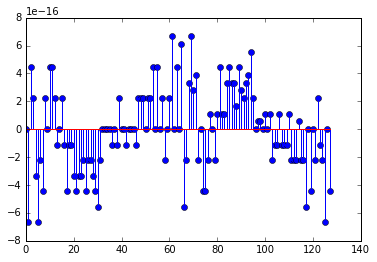

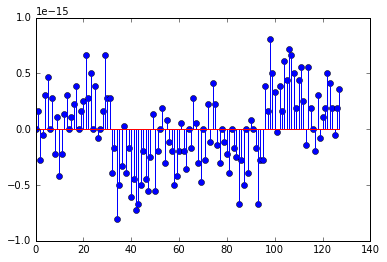

In [7]:
X = np.fft.fft(x)
x_hat = np.fft.ifft(X)

plt.stem(np.angle(X));
show();

plt.stem(np.real(x_hat - x));
show();

plt.stem(np.imag(x_hat));